In [1]:
from sklearn.datasets import fetch_california_housing

In [6]:
fetch_california_housing

<function sklearn.datasets._california_housing.fetch_california_housing(*, data_home=None, download_if_missing=True, return_X_y=False, as_frame=False, n_retries=3, delay=1.0)>

In [7]:
# as_frame=True tagastab DataFrame’i
data = fetch_california_housing(as_frame=True)
df   = data.frame

print("Andmestiku mõõtmed:", df.shape)
df.head()

Andmestiku mõõtmed: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


MedHouseVal – sihtmuutuja (tuhandetes dollarites).

Ülejäänud 8 veergu on numbrilised tunnused.

### Loo kolm erinevat ML mudelit (RandomForest, GradientBoosting, XgBoost) MedHouseVal prognoosimiseks ning võrdle tulemusi. Katseta mudelite parameetreid parema tulemuse saamiseks

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingRegressor
import joblib
import pathlib

In [17]:
from sklearn.metrics import r2_score, root_mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

# Lab 6

## We have to try out 3 different models based on data we got from `sklearn.dataset.fetch_california_housing`.

We will have to use different models:

- XGBoost (gradient boosting by the third-party library called XGBoost)
- DecisionTreeClassifier + manual gradient boosting
- Forests

We create an UI/UX for this to predict the model results.

## Gradient Boosting - XGBoost

> We do not re-use PandasService here, as redundant but we can preprocess if need to

In [8]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [12]:
print("Count NaN: ", df.isna().sum().sum())
print(df.dtypes)

Count NaN:  0
MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object


In [13]:
y = df["MedHouseVal"]
X = df.drop("MedHouseVal", axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train: ", X_train)

X_train:         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14196  3.2596      33.0  5.017657   1.006421      2300.0  3.691814     32.71   
8267   3.8125      49.0  4.473545   1.041005      1314.0  1.738095     33.77   
17445  4.1563       4.0  5.645833   0.985119       915.0  2.723214     34.66   
14265  1.9425      36.0  4.002817   1.033803      1418.0  3.994366     32.69   
2271   3.5542      43.0  6.268421   1.134211       874.0  2.300000     36.78   
...       ...       ...       ...        ...         ...       ...       ...   
11284  6.3700      35.0  6.129032   0.926267       658.0  3.032258     33.78   
11964  3.0500      33.0  6.868597   1.269488      1753.0  3.904232     34.02   
5390   2.9344      36.0  3.986717   1.079696      1756.0  3.332068     34.03   
860    5.7192      15.0  6.395349   1.067979      1777.0  3.178891     37.58   
15795  2.5755      52.0  3.402576   1.058776      2619.0  2.108696     37.77   

       Longitude  
14196    -

In [16]:
scaler = StandardScaler()
models = {
    "RandomForest": make_pipeline(scaler, RandomForestRegressor(random_state=42)),
    "GradientBoosting": make_pipeline(scaler, GradientBoostingRegressor(random_state=42)),
    "XGBoost": make_pipeline(scaler, xgb.XGBRegressor(random_state=42))
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print("R2 Score:", r2_score(y_test, preds))
    print("RMSE:", root_mean_squared_error(y_test, preds))


RandomForest
R2 Score: 0.8052747336256919
RMSE: 0.5051432839771741

GradientBoosting
R2 Score: 0.7756433164710084
RMSE: 0.5422167577867202

XGBoost
R2 Score: 0.8301370561019205
RMSE: 0.4717943691423984


In [19]:
param_dist = {
    "xgbregressor__n_estimators": [100, 200, 300],
    "xgbregressor__max_depth": [3, 5, 7],
    "xgbregressor__learning_rate": [0.01, 0.1, 0.2],
}

search = RandomizedSearchCV(models["XGBoost"], param_distributions=param_dist, cv=3)
search.fit(X_train, y_train)
print("Best XGBoost params:", search.best_params_)

Best XGBoost params: {'xgbregressor__n_estimators': 300, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.2}


In [ ]:
#joblib.dump(models["XGBoost"], "xgboost_model.joblib")
#joblib.dump(models["RandomForest"], "rf_model.joblib")
#joblib.dump(models["GradientBoosting"], "gb_model.joblib")

In [20]:
voting_reg = VotingRegressor(
    estimators=[
        ('rf', models["RandomForest"]),
        ('gb', models["GradientBoosting"]),
        ('xgb', models["XGBoost"])
    ]
)

voting_reg.fit(X_train, y_train)

y_pred = voting_reg.predict(X_test)

print("VotingRegressor R2 Score:", r2_score(y_test, y_pred))
print("VotingRegressor RMSE:", root_mean_squared_error(y_test, y_pred))

VotingRegressor R2 Score: 0.8239044743682735
VotingRegressor RMSE: 0.4803718953226395


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [5, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5],
}

pipeline = make_pipeline(StandardScaler(), RandomForestRegressor())

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best RandomForest params:", grid_search.best_params_)
print("Best R2:", grid_search.best_score_)


Best RandomForest params: {'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 300}
Best R2: 0.8025522812775104


In [24]:
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Tuned RandomForest R2 on Test:", r2_score(y_test, y_pred_rf))
print("Tuned RandomForest RMSE on Test:", root_mean_squared_error(y_test, y_pred_rf))

Tuned RandomForest R2 on Test: 0.8071700006799537
Tuned RandomForest RMSE on Test: 0.5026789854202931


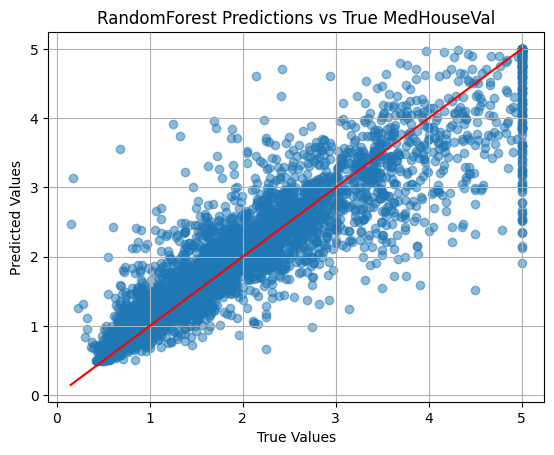

In [25]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("RandomForest Predictions vs True MedHouseVal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid()
plt.show()

In [26]:
rf_model = best_rf.named_steps['randomforestregressor']
importances = rf_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False))

      Feature  Importance
0      MedInc    0.526368
5    AveOccup    0.138464
6    Latitude    0.089500
7   Longitude    0.089014
1    HouseAge    0.053747
2    AveRooms    0.043251
4  Population    0.030619
3   AveBedrms    0.029037
